In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import FunctionTransformer

from sklearn import set_config
set_config(display='diagram')
# ------------------------------------------
import nltk
import sys
import random

from sklearn.feature_extraction.text import CountVectorizer

sys.path.append('..')
import utils
from sklearn.preprocessing import FunctionTransformer

## PROPIAS
from utils import RemoveStopWords
from utils import FeatureExtractionTwitts
from utils import LemmantizerTransformer



https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [2]:
df = pd.read_csv('training_tweets.csv', index_col = 0)
df;

In [3]:
groups_classes = {
                    'happiness' : 'positiva',
                    'surprise'  : 'positiva',
                    'love'      : 'positiva',
                    'fun'       : 'positiva',
                    'relief'    : 'positiva',
                    'enthusiasm': 'positiva',
                    'worry'     : 'negativa',
                    'hate'      : 'negativa',
                    'sadness'   : 'negativa',
                    'empty'     : 'negativa',
                    'boredom'   : 'negativa',
                    'anger'     : 'negativa',
                    'neutral'   : 'neutral'
                }
neutral_class_name = 'neutral'
target_var_name = 'sentiment'



In [9]:
df_preprocess = Pipeline(steps=[
                ('regroup_classes', 
                    FunctionTransformer(
                        utils.multi_class_remapping, 
                        kw_args={
                            'group_classes': groups_classes,
                            'var_name': target_var_name,
                            'neutral_class': neutral_class_name,
                            'random_state': 42
                            }))
])

df = df_preprocess.transform(df) # este preprocess del df es solo para remapear las clases del target. Preguntar a Alfonso como incluir esta etapa en el pipeline completo.

preprocessing = Pipeline(steps=[
                ('ra', FunctionTransformer(utils.remove_arrobas, kw_args= {'var_name':'content'})),
                ('rsw', RemoveStopWords(text_columns = ['content_remarroba'])),
                ('lt', LemmantizerTransformer(text_columns = ['content_remarroba_sw'], stemmers=['ps'])),
                # 
])

feature_extraction = Pipeline(steps=[
                ('fet_1', FeatureExtractionTwitts(
                    text_column="content",
                    features_to_extract=[
                        "arrobas_count", "hashtag_count", "is_reply", "is_rt", "twitt_length"]
                    )),
                ('fet_2', FeatureExtractionTwitts(
                    text_column="content_remarroba_sw_ps",
                    features_to_extract = ["subjectivity", "polarity"]
                    )),
                # ('reorder', FunctionTransformer(utils.columns_reorder, kw_args={'new_columns_ordered': new_ordered_columns})),
])
new_ordered_columns = df.columns[df.columns.str.contains('content')].to_list(
) + df.columns[df.columns.str.contains('var')].to_list() + df.columns[df.columns.str.contains('sentiment')].to_list()

# joblib.load
# TransformedTargetRegressor
# DropFeatures

In [10]:
pipe = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
])

X = df[['content']]
y = df.sentiment_remapped
X_tr = pipe.fit_transform(X,y)
X_tr 


c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{var_name}_remarroba'] = X[var_name].apply(lambda s: re.sub(r'(\@[a-zA-Z0-9\-\_]*)', '', s))


,content,content_remarroba,content_remarroba_sw,content_remarroba_sw_ps,var_arrobas_count,var_hashtag_count,var_is_reply,var_is_rt,var_twit_length,var_subjectivity,var_polarity
34723,Happy Mama's day to all mothers,Happy Mama's day to all mothers,happy mama's day mothers,happi mama 's day mother,0,0,0,0,31,0.000000,0.000000
17493,@LysdelTellez I am lost. Please help me find a...,I am lost. Please help me find a good home.,i lost. please help find good home.,i lost . pleas help find good home .,1,0,1,0,57,0.600000,0.700000
20198,"@BoomKatt yes yes I AM, networking whore to th...","yes yes I AM, networking whore to the fullest...","yes yes i am, networking whore fullest..........","ye ye i am , network whore fullest ....... and...",1,0,1,0,93,0.000000,0.000000
6855,you@snapplynn Wish that would have been your t...,you Wish that would have been your tweet after...,wish would tweet followed me.,wish would tweet follow me .,1,0,0,0,73,0.000000,0.000000
5924,now i am doing the MicroEconomics project iha...,now i am doing the MicroEconomics project iha...,microeconomics project ihate subject &amp; be...,microeconom project ihat subject & amp ; besid...,0,0,0,0,133,0.166667,-0.083333
...,...,...,...,...,...,...,...,...,...,...,...
16469,I do not want to work tomorrow!,I do not want to work tomorrow!,i want work tomorrow!,i want work tomorrow !,0,0,0,0,32,0.000000,0.000000
36006,@KandyBee we shuld do a dance like that its s...,we shuld do a dance like that its seriously ...,shuld dance like seriously best thing haha. ...,shuld danc like serious best thing haha . see ...,1,0,1,0,90,0.422222,0.288889
22647,"Photo: Got my prints a few days ago, ready for...","Photo: Got my prints a few days ago, ready for...","photo: got prints days ago, ready norskart exh...","photo : got print day ago , readi norskart exh...",0,0,0,0,99,0.000000,0.000000
21478,@tove_liden Thanks for the follow Tove!,Thanks for the follow Tove!,thanks follow tove!,thank follow tove !,1,0,1,0,39,0.000000,0.000000


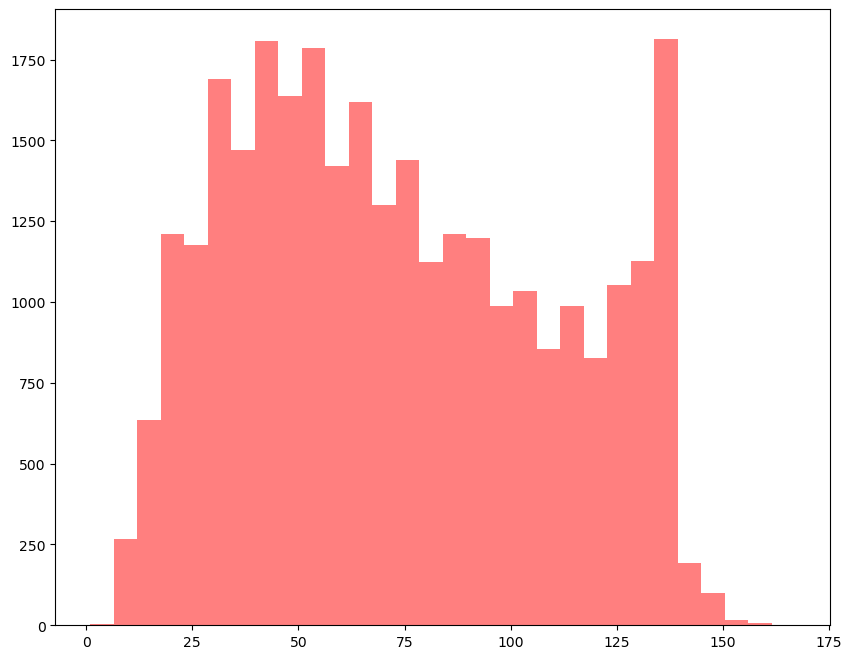

In [11]:
# plt.figure(figsize=(10, 8))
# plt.hist(X_tr['var_subjectivity'], bins=30, fc=(1, 0, 0, 0.5))
# plt.hist(X_tr['var_polarity'], bins=30, fc=(0, 0, 1, 0.5))
# # for i in range(0, X_tr.shape[0]):
# # plt.title('Sentiment analysis')
# # plt.xlabel('Polarity')
# # plt.ylabel('Subjectivity')
# plt.show()

plt.figure(figsize=(10, 8))
plt.hist(X_tr['var_twit_length'], bins=30, fc=(1, 0, 0, 0.5))
# for i in range(0, X_tr.shape[0]):
# plt.title('Sentiment analysis')
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
plt.show()

# from nltk.corpus import subjectivity
# from nltk.sentiment import SentimentAnalyzer
# from nltk.sentiment.util import *



In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer


cvec = TfidfVectorizer()
text_preprocessing = Pipeline([('Vect', cvec)])
preproc = ColumnTransformer([('text_preprocessing', text_preprocessing, 'content_ps_min')])
Sa = preproc.fit_transform(X_tr)


ss = pd.DataFrame(Sa.todense().astype('int8'))
ss
# ss[34662].value_counts()

ValueError: A given column is not a column of the dataframe

In [ ]:
tf = TfidfVectorizer()
string = 'Ah! Now I have done Philosophy,\nI have finished Law and Medicine,\nAnd sadly even Theology:\nTaken fierce pains, from end to end.\nNow here I am, a fool for sure!\nNo wiser than I was before:'
pd.DataFrame(string.split('\n'))


In [ ]:

pipece = ColumnTransformer([('tf', tf, ['h'])])
pipece.fit_transform(pd.DataFrame(string.split('\n'), columns = ['h']))


In [ ]:
# for i in [0,1,2]:
#     display(cvec.fit_transform(T[i]).shape)